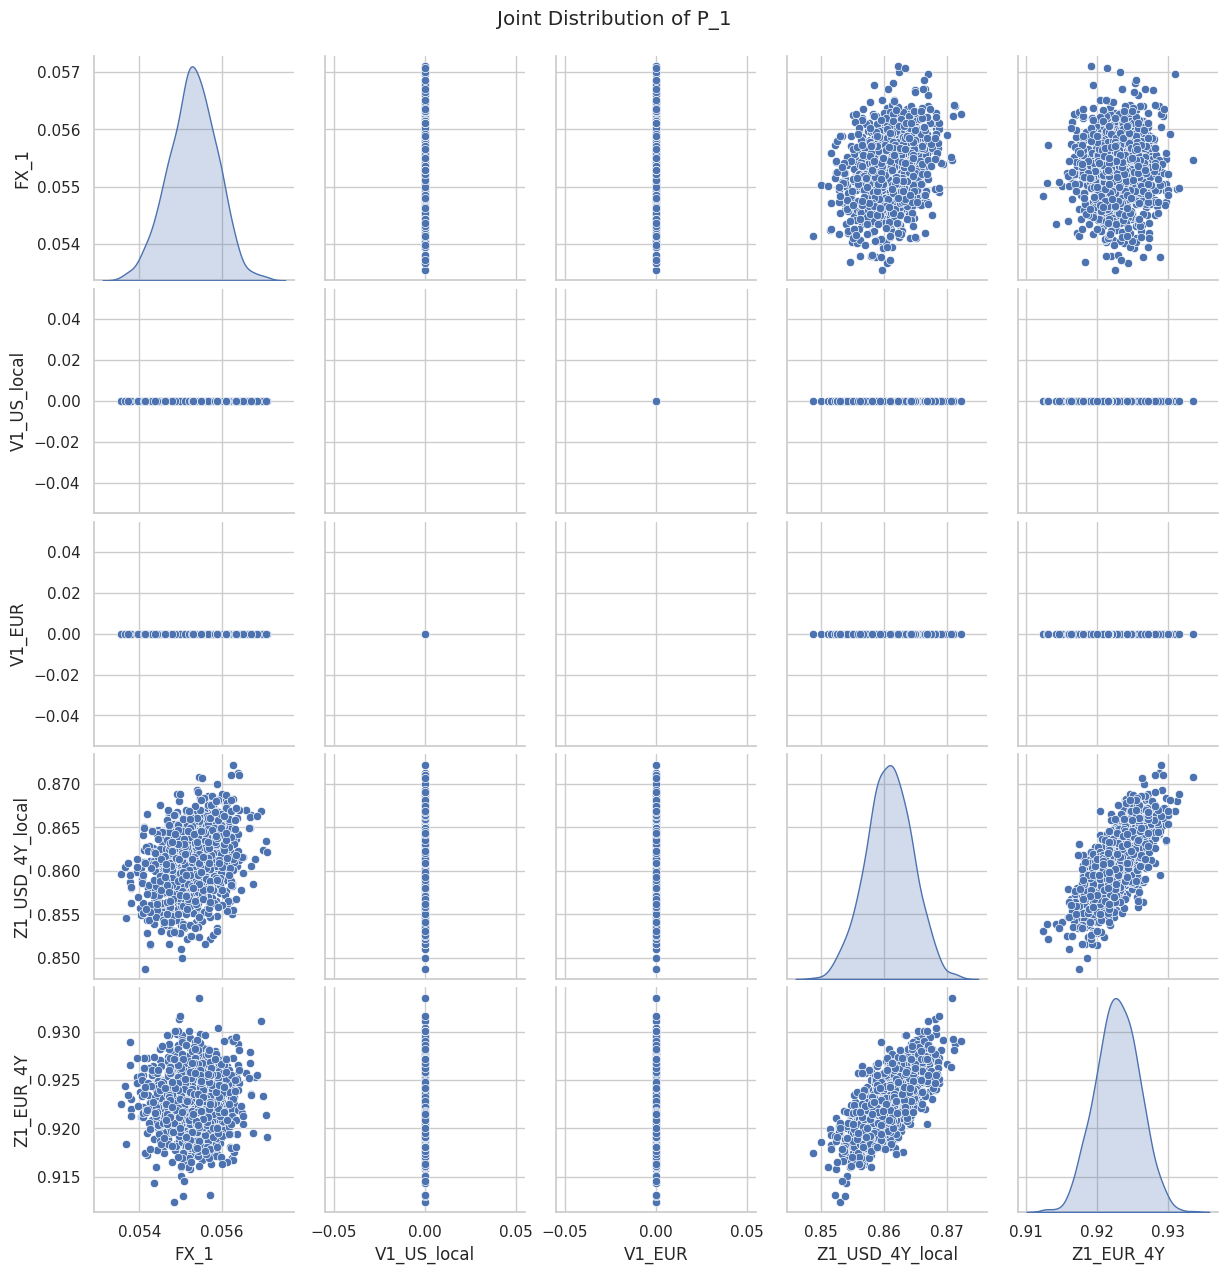

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# ------------------------------------
# Step 1: Load Data (Replace these with your actual file paths and sheet names)
# ------------------------------------
# Suppose we have:
# - init_values.xlsx containing initial FX_0, V_0^{US,local}, V_0^{EUR}, and yields
# - covariance_matrix.xlsx containing the covariance of increments

init_values = pd.read_excel('init_values.xlsx', index_col=0)
cov_matrix = pd.read_excel('covariance_matrix.xlsx', index_col=0)

# Extract initial values (replace the keys with the exact names from your file)
FX_0 = init_values.loc['fx_spot', 'initial values']
V0_US_local = init_values.loc['EQV US', 'initial values']
V0_EUR = init_values.loc['EQV EUR', 'initial values']
y_5y_US = init_values.loc['5Y USD', 'initial values']
y_5y_EUR = init_values.loc['5Y EUR', 'initial values']

# Assume we know the indexes of the increments we need in the covariance matrix:
# For example (THIS IS JUST AN EXAMPLE):
# 'log_FX' at index i_fx
# 'log_VUS_local' at index i_vus
# 'log_VEUR' at index i_veur
# 'y_5y_US_change' at index i_yus
# 'y_5y_EUR_change' at index i_yeur
# In practice, find these by checking cov_matrix.index for the correct rows.
i_fx = cov_matrix.index.get_loc('fx_spot')        # Example
i_vus = cov_matrix.index.get_loc('EQV US')         # Example
i_veur = cov_matrix.index.get_loc('EQV EUR')       # Example
i_yus = cov_matrix.index.get_loc('5Y USD')         # Example
i_yeur = cov_matrix.index.get_loc('5Y EUR')        # Example

# Create a mean vector (assuming zero mean increments for simplicity; replace as needed)
mean_vector = np.zeros(len(cov_matrix))

# Extract the required sub-block from the covariance matrix and mean vector
# If we only want these 5 increments, we create an index list:
indices = [i_fx, i_vus, i_veur, i_yus, i_yeur]

sub_mean = mean_vector[indices]
sub_cov = cov_matrix.iloc[indices, indices].values

# ------------------------------------
# Step 2: Simulate the increments
# ------------------------------------
N = 10000
rng = np.random.default_rng()

increments = rng.multivariate_normal(mean=sub_mean, cov=sub_cov, size=N)

# increments[:,0] corresponds to Δlog(FX)
# increments[:,1] corresponds to Δlog(V^{US,local})
# increments[:,2] corresponds to Δlog(V^{EUR})
# increments[:,3] corresponds to Δy_{USD,5y}
# increments[:,4] corresponds to Δy_{EUR,5y}

delta_log_FX = increments[:,0]
delta_log_VUS = increments[:,1]
delta_log_VEUR = increments[:,2]
delta_y_US_5y = increments[:,3]
delta_y_EUR_5y = increments[:,4]

# Compute final values:
FX_1 = FX_0 * np.exp(delta_log_FX)
V1_US_local = V0_US_local * np.exp(delta_log_VUS)
V1_EUR = V0_EUR * np.exp(delta_log_VEUR)

# After one year, the 5y bond at t=0 becomes a 4y bond at t=1:
# Final yields at horizon:
y_US_4y = y_5y_US + delta_y_US_5y
y_EUR_4y = y_5y_EUR + delta_y_EUR_5y

Z1_USD_4Y_local = np.exp(-4 * y_US_4y)
Z1_EUR_4Y = np.exp(-4 * y_EUR_4y)

# ------------------------------------
# Step 3: Construct the vector P_1 and visualize
# ------------------------------------
P_1 = np.column_stack([FX_1, V1_US_local, V1_EUR, Z1_USD_4Y_local, Z1_EUR_4Y])

# P_1 now holds N simulations of the joint distribution.
# Let's put it into a DataFrame for easier handling:
columns = ['FX_1', 'V1_US_local', 'V1_EUR', 'Z1_USD_4Y_local', 'Z1_EUR_4Y']
df = pd.DataFrame(P_1, columns=columns)

# ------------------------------------
# Step 4: Visualization
# ------------------------------------
# Use pairplot to visualize the joint distribution of these variables
sns.set(style="whitegrid")
pairplot_fig = sns.pairplot(df.sample(1000), diag_kind='kde')  # sample 1000 points for clarity
plt.suptitle('Joint Distribution of P_1', y=1.02)
plt.show()

# The pairplot will show scatter plots of each pair of variables and their marginal distributions.
# You'll see that each marginal looks approximately lognormal and the joint distributions show correlation structures.


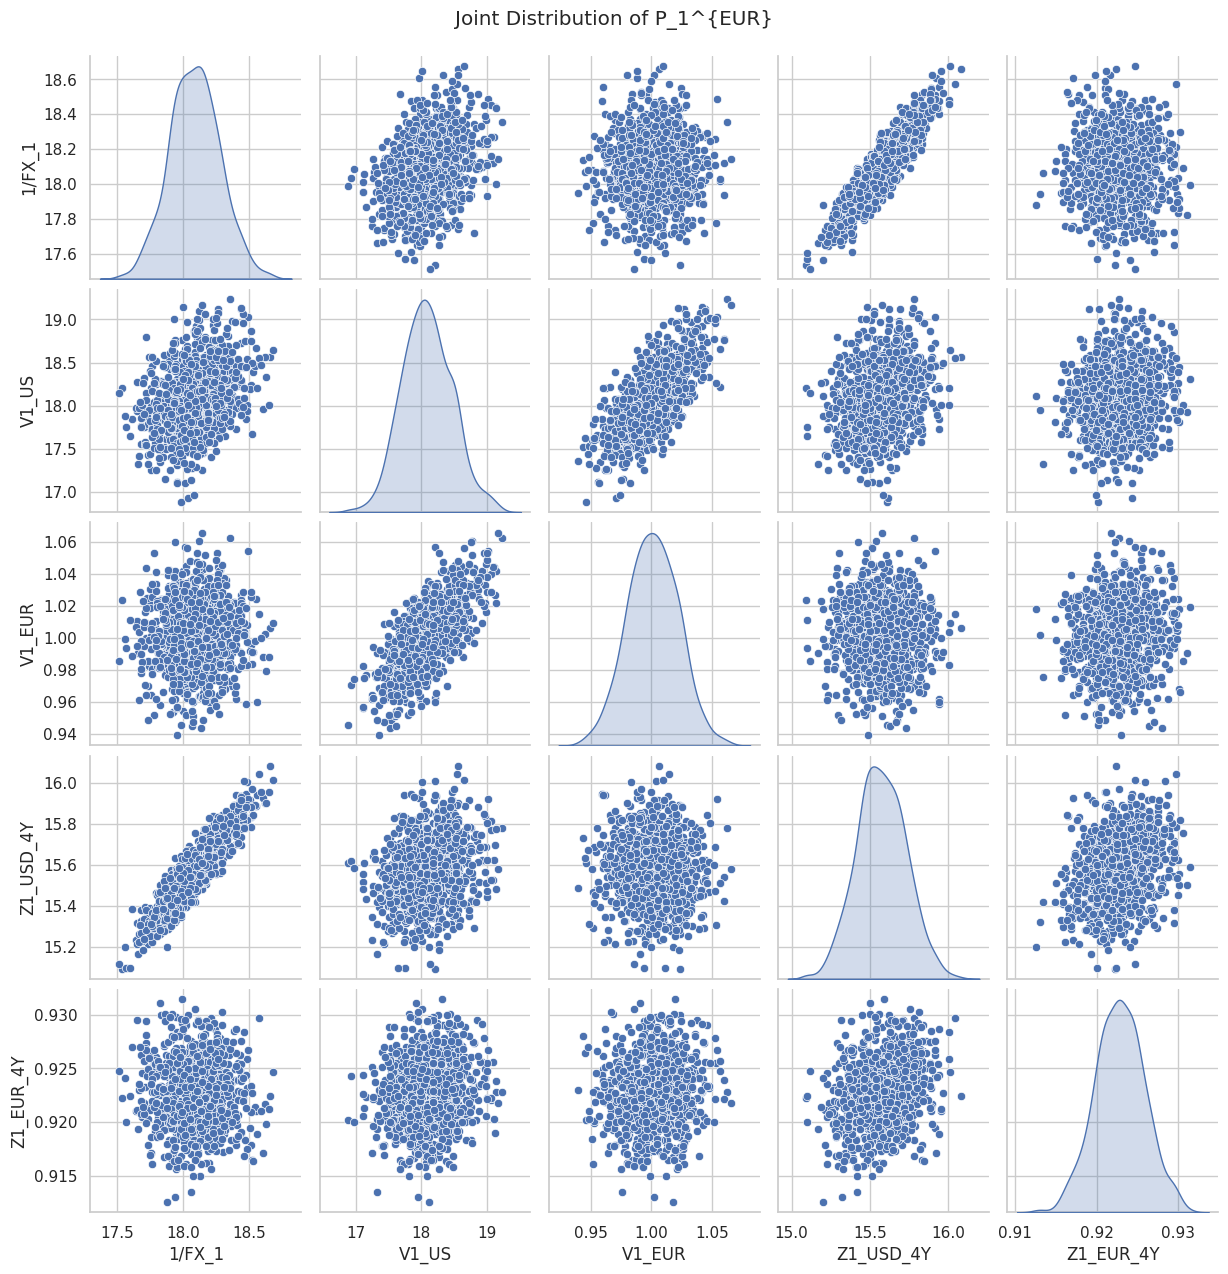

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# Step 1: Load Data
# -------------------------
init_values = pd.read_excel('init_values.xlsx', index_col=0)
cov_matrix = pd.read_excel('covariance_matrix.xlsx', index_col=0)

# Extract initial values
# Assuming EQV US and EQV EUR are given as log-values. For instance, if init_values shows EQV US = 0.0000,
# that might mean log(V0_US_local)=0. Then V0_US_local = exp(0)=1.
FX_0 = init_values.loc['fx_spot', 'initial values']
V0_US_local = np.exp(init_values.loc['EQV US', 'initial values'])   # interpret as log-price
V0_EUR = np.exp(init_values.loc['EQV EUR', 'initial values'])        # interpret as log-price
y_5y_US = init_values.loc['5Y USD', 'initial values']                # continuous yield
y_5y_EUR = init_values.loc['5Y EUR', 'initial values']               # continuous yield

# Identify indices in the covariance matrix
# Ensure these match the naming convention in your files. If "fx_spot", "EQV US", etc. represent increments
# of log values and yields, confirm the rows in covariance_matrix.xlsx.
i_fx = cov_matrix.index.get_loc('fx_spot')     
i_vus = cov_matrix.index.get_loc('EQV US')
i_veur = cov_matrix.index.get_loc('EQV EUR')
i_yus = cov_matrix.index.get_loc('5Y USD')
i_yeur = cov_matrix.index.get_loc('5Y EUR')

indices = [i_fx, i_vus, i_veur, i_yus, i_yeur]

mean_vector = np.zeros(len(cov_matrix))  # adjust if you have known means
sub_mean = mean_vector[indices]
sub_cov = cov_matrix.iloc[indices, indices].values

# -------------------------
# Step 2: Simulate increments
# These increments are assumed to be Δlog(FX), Δlog(VUS), Δlog(VEUR), Δy_US_5y, Δy_EUR_5y
# -------------------------
N = 10000
rng = np.random.default_rng()
increments = rng.multivariate_normal(mean=sub_mean, cov=sub_cov, size=N)

delta_log_FX = increments[:,0]
delta_log_VUS = increments[:,1]
delta_log_VEUR = increments[:,2]
delta_y_US_5y = increments[:,3]
delta_y_EUR_5y = increments[:,4]

# -------------------------
# Step 3: Compute final values in original terms
# -------------------------
FX_1 = FX_0 * np.exp(delta_log_FX)           # FX_1 = FX_0 * exp(Δlog(FX))
V1_US_local = V0_US_local * np.exp(delta_log_VUS) # V1_US_local = V0_US_local * exp(Δlog(VUS))
V1_EUR = V0_EUR * np.exp(delta_log_VEUR)          # V1_EUR = V0_EUR * exp(Δlog(VEUR))

# After 1 year, a 5y bond at t=0 is a 4y bond at t=1
y_US_4y = y_5y_US + delta_y_US_5y
y_EUR_4y = y_5y_EUR + delta_y_EUR_5y

Z1_USD_4Y_local = np.exp(-4 * y_US_4y) # USD zero-coupon bond price in USD
Z1_EUR_4Y = np.exp(-4 * y_EUR_4y)      # EUR zero-coupon bond price in EUR

# -------------------------
# Step 4: Convert everything into EUR terms
# According to the problem statement:
# P_1^{EUR} = (1/FX_1, V_1^{US}, V_1^{EUR}, Z_1^{USD,4Y}, Z_1^{EUR,4Y})^T
#
# V_1^{US} in EUR = (V_1^{US,local} / FX_1)
# Z_1^{USD,4Y} in EUR = (Z_1^{USD,4Y,local} / FX_1)
#
# Everything else is already in EUR terms.
# 1/FX_1 is just the reciprocal of FX_1.

one_over_FX1 = 1.0 / FX_1
V1_US = V1_US_local / FX_1
Z1_USD_4Y = Z1_USD_4Y_local / FX_1

P_1_EUR = np.column_stack([one_over_FX1, V1_US, V1_EUR, Z1_USD_4Y, Z1_EUR_4Y])
columns = ['1/FX_1', 'V1_US', 'V1_EUR', 'Z1_USD_4Y', 'Z1_EUR_4Y']

df_eur = pd.DataFrame(P_1_EUR, columns=columns)

# -------------------------
# Step 5: Visualize the joint distribution
# -------------------------
sns.set(style="whitegrid")
pairplot_fig = sns.pairplot(df_eur.sample(1000), diag_kind='kde')
plt.suptitle('Joint Distribution of P_1^{EUR}', y=1.02)
plt.show()

